<h2>Data Science in Python</h2>


In [13]:
import urllib
import bs4
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from sklearn import metrics

In [14]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
plt.style.use('classic')

<h3>Objective</h3>
<b>The objective is to scrape a corpus of news articles from a set of web pages contained in the base web page :http://mlg.ucd.ie/modules/COMP41680/archive/index.html and then pre process the corpus and to build and train classifiers that can automatically classify articles in a supervised learning context. </b>


<h3><font color ="red">Data Scraping - Data Collection</font></h3>

<b>This Link to the pages from which data was scrapped and the saved  </b>

In [26]:
link = "http://mlg.ucd.ie/modules/COMP41680/archive/index.html"

In [27]:
#opening the link and then decoding the response and storing it to the html vairable
response = urllib.request.urlopen(link)
html = response.read().decode()

<b>Beautiful Soup Package was used to find the links in the landing page</b>

In [28]:

linklists=[] # list to store the links that we get from the home pages.
soup=BeautifulSoup(html,"lxml") # creating a beautiful soup object from the reponse object
#finding all a tags and then extracting the href part from the resonse and storing them in a list which 
#contains all the links.
for link in soup.find_all('a'): 
    if link.get('href') != 'index.html' and link.get('href') != '':
        linklists.append(link.get('href'))

<b>The links in the list of links created is iterated and then appended to the main portion of the 
the link to get the link to open the page which contains the list of articles in that month . Each link in the list is opened and their corresponding repsonses are converter to the soup ofbject of Beautiful soup and then All the tr tags are searched for. From each of the tr tag td tags with class labels category and title are extracted and the a tag and its corresponding href which contains the link to the article content is fetched and stored to their corresponding variables. There variables are then put to an array and appended to the array list called arlist.In each iteration a dataframe is populated caled the 'dataframe' which is made from the arlist array list of category,title,links rows and this dataframe is then appended to a main dataframe which collects all the information for the dataframe generated in each iteration. So the dataframe - 'maindf ' contains the information about the pages and their link and categories.</b>

In [29]:
maindf=pd.DataFrame(columns=["Title","Category","Link","LinkPart"])
for link in linklists:
    appendedLink="http://mlg.ucd.ie/modules/COMP41680/archive/"+link #appending the link part
    #print(appendedLink)
    response = urllib.request.urlopen(appendedLink)
    html = response.read().decode()
    soup=BeautifulSoup(html,"lxml")
    linkpart="http://mlg.ucd.ie/modules/COMP41680/archive/"
    arlist=[]
    trs=soup.find_all('tr') #finding all the tr tags in the reponse
    trs.pop(0)#to pop the first junk record out
    for tr in trs: #iterating each tr
        #print(tr)
        ar=[]
        #getting the category of each articles
        category_box = tr.find('td', attrs={'class': 'category'})
        cat =category_box.text.split()
        #print(cat)
        #Getting the title of each article
        title_box = tr.find('td', attrs={'class':'title'})
        title = title_box.text.strip()
        #print(title)
        #finding the link the article body
        link=tr.find('a')
        ar.append(title)
        ar.append(cat)
        link=tr.find('a')
        if(link):
            appendedlink=linkpart+link.get('href')
            ar.append(appendedlink)
            ar.append(link.get('href'))
        else: #if link not avaialable case
            appendedlink="Not Available"
            ar.append(appendedlink)
            ar.append("None")
        arlist.append(ar) #appending to the list
    dataframe = pd.DataFrame(arlist,columns=["Title","Category","Link","LinkPart"])
    #print(dataframe)
    #appending the dataframe to the main dataframe
    maindf=maindf.append(dataframe) #appening the dataframes
    dataframe.empty #clearing the temp dataframe
    

<b>Pre Processing the Dataframe</b>

In [30]:
#converting the maindf to drop values which has None for linkPart
maindf = maindf[maindf.LinkPart != 'None']

<b>The Sklearn preprocessing.LabelEncoder has been used to convert the catergorical labels to numerical ones so as to make the classification and training of the classifiers easier. The class labels are Business,Sport and Technology which are then converted to their label values.</b>

In [31]:
#converting the category labels to numerical labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(maindf["Category"])
le.classes_
maindf["Category"]=le.transform(maindf["Category"])

In [32]:
maindf.head() # after encoding categories to numerical values

,Title,Category,Link,LinkPart
0,21st-Century Sports: How Digital Technology Is...,2,http://mlg.ucd.ie/modules/COMP41680/archive/ar...,article-jan-0418.html
1,Asian quake hits European shares,0,http://mlg.ucd.ie/modules/COMP41680/archive/ar...,article-jan-0027.html
2,BT offers free net phone calls,2,http://mlg.ucd.ie/modules/COMP41680/archive/ar...,article-jan-0631.html
3,Barclays shares up on merger talk,0,http://mlg.ucd.ie/modules/COMP41680/archive/ar...,article-jan-2105.html
4,Barkley fit for match in Ireland,1,http://mlg.ucd.ie/modules/COMP41680/archive/ar...,article-jan-3300.html


In [33]:
le.classes_ # Class labels in the data set

array([list(['business']), list(['sport']), list(['technology'])],
      dtype=object)

In [34]:
# Category number created for each of the category label
ppp=maindf["Category"]
ppp.unique()

array([2, 0, 1])

<b>Comparing the number of articles in each category</b>

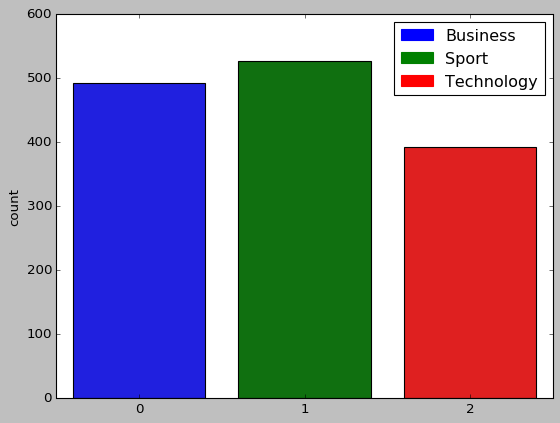

In [35]:
#plotting the number of records in each class in the data set
import matplotlib.patches as mpatches
categories=maindf["Category"]
categoryList=categories.tolist();
sns.countplot(categoryList)
business = mpatches.Patch(color='blue', label='Business')
sport = mpatches.Patch(color='green', label='Sport')
technology = mpatches.Patch(color='red', label='Technology')
plt.legend(handles=[business,sport,technology])

plt.show()

<b> The links to the article content in the main dataframe is iterated and opened and the div tag with the class main is extracted from the response. From the extracted div the h2 tags and all the p tags which contains the content of the article is appened to a variable and all the information is stored in a text file with the filename as the last portion of the article link which is unique for every article and the category seperated by a underscore. eg "article123123_2"</b>

In [36]:
#saving the content to files as filename_category
for i in range(maindf.shape[0]):
    link = maindf.iloc[i]["Link"] #getting the link part for each row
    category = maindf.iloc[i]["Category"]  #getting the category for the row
    if link != "Not Available": #if link value is not equal to not available then open the link and get the response
        response1 = urllib.request.urlopen(link)
        html1 = response1.read().decode()
        soup1=BeautifulSoup(html1,"lxml")
        maindiv=soup1.find('div', attrs={'class': 'main'})#finding div with class main
        heading=maindiv.find('h2') #finding h2 tags
        heading.text.strip()
        body=maindiv.find_all('p', attrs={'class': None}) #finding p tags
        b=""
        for p in body:
            b=b+p.text.strip()
        finaltext=heading.text.strip()+" "+b
        f = open("./TextFiles/"+link[-21:-5]+"_"+str(category)+".txt","w")#saving the file with linkpart and category in the name
        f.write(finaltext)
            #print(i)
        f.close()
    

### <font color="red">Data Preprocessing</font>

<b>The os package was used to load the filesname which were saved in the previous step. The files were saved as the LinkPart value in the datafrme maindf and then the category seperated by an underscore as the filename. </b>

In [3]:
import os
#getting the names of the files.
filenames = [i for i in os.listdir("./TextFiles/") if not i.startswith('.') if not i=='test' if not i.startswith('blah.csv')  \
            if not i.startswith('Data')]
len(filenames)

1408

<b>1408 files were created and saved</b>

<h4>Preprocessing content of the files to train the classifiers</h4>
<b>Tokenized -> Stop Words Removed -> Infrequent Terms Removed (Less than 3) -> 1 and 2 grams taken -> Lemmatized<b>

<b>The files are being loaded using the filenames got from the previous step and then its category was stripped from the name and stored into another list called catList</b>

In [4]:
#defining lists to store tokens, an categories for each of the documents.
docList=[]
catList=[]
#Loading all the contents of the filenames to a list of list(strings) -> docList
#Loading the categories for the corresponding files from the filename to a list -> catList
for name in filenames:
    fin = open("./TextFiles/"+name,"r")
    raw_documents = fin.readlines()
    fin.close()
    docList.append(raw_documents)
    catList.append(name[-5:-4]) # extracting the category from the filename

In [5]:
#converting the list of list(strings) created to list(strings)
changedDocList=[]
for doc in docList:
    t=doc[0]
    changedDocList.append(t)

<b>Lemmatization is a preprocessing step in which the words are reduced to their canonical forms which is an advanced form of stemming. This is done with the help of the WordNetLemmatizer from the nltk package. The function tokenizes the text using the CountVectorizer and then lemmatizes the token and returns the list of tokens.</b>

In [6]:
# function to lemmatize the text content to bring about normalization.
def lemma_tokenizer(text):
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    lemmatizer = nltk.stem.WordNetLemmatizer() # the lemmatizer WordNetLemmatizer is stored to the lemmatizer object.
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    return lemma_tokens

<b>The CountVectorizer from sklearn is used to preprocess the text. The CountVectorizer takes parameters to remove english stopwords , set a minimum frequency of 3, tokenize and lemmatize using the defined function and to consider ngrams of length 1 and 2. The CountVectorizer returns a sparse matrix of scipy after the fit_Transform function of the vectorizer is used on the list containing the documents as strings. So the result returned by the CountVectorizer is then used to build the TF_IDF Matrix.</b>

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
vectorizer = CountVectorizer(stop_words="english",min_df = 3,tokenizer=lemma_tokenizer,ngram_range=(1,2))
X = vectorizer.fit_transform(changedDocList)
print(X.shape)

(1408, 20653)


In [8]:
type(X)

scipy.sparse.csr.csr_matrix

<b>TF-IDF -> Is a common approach in weighting the score for each term in a document using two parts the TF - Term Frequency which is the number of times a word appears in a single document and the IDF - Inverse Document Frequency which is a function of the number of distinct documents containing a term which is to penalize the effect of common terms that appear in almost every document. The Sklearn TfidfTransformer is used to transform the output to TF-IDF sparse matrix which is the output which is used to train the classifiers. The input to the fit_transform function of the TfidfTransformer is the output of the CountVectorizer on the list of list of string containing the document content which gives a sparse matrix. This is then input to the fit_transform method which then converts it into TF_IDF Matrices. 

- Term frequency-inverse document frequency (TF-IDF) is a numerical statistic method which allows the
determination of weight for each term (or word) in each document. The method is often used in natural language
processing (NLP) or in information retrieval and text mining. The method determines the weight, measure
which evaluates importance of terms (or words) in document collection. The importance of the text is increased
proportionally to the number of appearing in the documents. 

Ref: https://ac.els-cdn.com/S1877705814003750/1-s2.0-S1877705814003750-main.pdf?_tid=6f4b0453-d1ef-47cc-88f9-b9ec25f227b1&acdnat=1524921581_973d97cd6ce5c783e605d0d14fa95cc2</b>

### <font color="red">Classification and Evaluation</font>

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer() #TfidfTransformer to transform the input matrix to the TF_IDF matrix.
X = tfidf_transformer.fit_transform(X)

<b>The sklearn model_Selection train_test_split was used to split the data into train and test parts to train and evaluate the classifiers. The training size is 70% of the full data set and the rest is for the test set to evaluate the performance of the classifier.</b>

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test \
    = train_test_split(X, catList, random_state=0, \
                                    test_size = 0.3)

<b>The Sklearn package classifers were used to train and evaluate.
The KNeighborsClassifier,Multinomial Naive Bayes,Linear SVC where used for training the models and evaluating them as these are the commonly used for classification purposes of text classification.
The training of the classifiers where done using the X_Train and y_train splits and testing with the other two.
Their accuracy was found using the sklearn metrics.accuracy_Score function which compares the predicted values of the trained classifier with the known target values to give the performance details. </b>

<b>The sklearn metrics was used to find the accuracy of the models trained below</b>

<b><h3>KNN Classifier</h3></b>

<b>
> KNN is a non-parametric, lazy learning algorithm.When we say a technique is non-parametric , it means that it does not make any assumptions on the underlying data distribution. In other words, the model structure is determined from the data.Therefore, KNN could and probably should be one of the first choices for a classification study when there is little or no prior knowledge about the distribution data.KNN Algorithm is based on feature similarity: How closely out-of-sample features resemble our training set determines how we classify a given data point. So it consideres training points based on the n_neighbour parameter to consider how many data points near to the given data point to make a prediction based on a similarity measure usually Euclidean Distance
 
 
 Advantages
* Insensitive to outliers
* No assumptions about data
* High accuracy
 
 Cons
* Computationally expensive
* High memory requirement
* Prediction stage might be slow
* Sensitive to irrelevant features and the scale of the data

ref:https://medium.com/@adi.bronshtein/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7


</b>

In [45]:
###CLassifying

from sklearn.neighbors import KNeighborsClassifier #importing the knn classifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)# training the model
# Make a set of predictions for the test data
y_pred =model.predict(X_test) #making the trained classifier predict on the test data set.
#performance
knn_accuracy = metrics.accuracy_score(y_test, y_pred) #comparing the predicted values with the target values.
print("Accuracy: " +  str(knn_accuracy))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.9408983451536643
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       149
          1       0.97      0.96      0.96       158
          2       0.92      0.94      0.93       116

avg / total       0.94      0.94      0.94       423



<b>The KNN Classifier is trained on the X_train and y_train lists which are the training sets using the fit() function for the model. Then the model is made to predict on the X_test data set and the predicted vales is then used to calculate the accuracy it has by comparing it with the original target labels y_test of the test split. The accuracy was found to be 94.08 Percent with a recall and f1 score of 94 %. KNN used had a k values of 3 that is it considers 3 nearest neighbours to make a prediction and it seems to do a good job in classifying the documents with a accuracy percentage of 94 </b>

<b><h3>Linear SVC Classifier</h3></b>

<b> Support Vector Machine Classifier
> SVM is a supervised machine learning algorithm that can be used for classification as well as regression tasks. The SVM classifiers goal is to find the best hyperplane that best divides as dataset into classes. A hyperplane is line that separates and classifies a set of data.

Pros.
>* Accuracy
>* Best when working on Small but clean datasets.

Cons.
>* With large datasets the training tends to take longer time.
>* Less effective on noisy dataset.

Linear SVC
>LinearSVC is another implementation of Support Vector Classification for the case of a linear kernel.The objective of a Linear SVC is to fit to the data you provide, resulting a best appropriate fit for hyperplane that divides, or categorizes, your data. Linear SVC is a good text classifiction multiclass classifier
</b>

In [51]:
from sklearn.svm import LinearSVC
svc=LinearSVC()
svc.fit(X_train,y_train)#training
# Make a set of predictions for the test data
y_pred =svc.predict(X_test) #making the trained classifier predict on the test data set.
#performance
svc_accuracy = metrics.accuracy_score(y_test, y_pred) #comparing the predicted values with the target values.
print("Accuracy: " +  str(svc_accuracy))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.9787234042553191
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       149
          1       0.99      0.98      0.98       158
          2       0.97      0.97      0.97       116

avg / total       0.98      0.98      0.98       423



<b>The Linear SVC Classifier performs really well for the current text classification problem where it gets an accuracy of 97.87% and doog precision,recall and f1 scores of 98%. Which is very good compared to the performance of KNN Classifier which is around 4 percent more.</b>

<b><h3>Multinomial Naive Bayes</h3></b>

<b>
Multinomial Naive Bayes
>* Bayes theorem provides a way of calculating posterior probability P(c|x) from P(c), P(x) and P(x|c) which the naive bayes classifier uses to predict the probability of a data sample belonging to a particular sample.
>* The general term Naive Bayes refers to the strong independence assumptions in the model, rather than the particular distribution of each feature. A Naive Bayes model assumes that each of the features it uses are conditionally independent of one another given some class. The term Multinomial Naive Bayes simply lets us know that each p(fi|c) is a multinomial distribution, rather than some other distribution. This works well for data which can easily be turned into counts, such as word counts in text.


Pros.
>Perform well in multi class prediction.
>Naive Bayes classifier performs better compare to other models like logistic regression and you need less training data with the assumption of independence.


Cons.
>Zero Frequency Error : If the data point has a category which was not in the training set then the model will assign 0 probability and will make it not able to make a prediction.
>The predict_proba outputs of the classifier cant be depended upon as it is a bad estimator.
>The assumption of independence predictors which is not the case in most of the real case scenarios.

ref :https://stats.stackexchange.com/questions/33185/difference-between-naive-bayes-multinomial-naive-bayes

</b>

In [53]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(X_train,y_train)#training
# Make a set of predictions for the test data
y_pred =nb.predict(X_test) #making the trained classifier predict on the test data set.
#performance
nb_accuracy = metrics.accuracy_score(y_test, y_pred) #comparing the predicted values with the target values.
print("Accuracy: " +  str(nb_accuracy))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.9763593380614657
             precision    recall  f1-score   support

          0       0.98      0.97      0.97       149
          1       0.99      0.98      0.98       158
          2       0.96      0.98      0.97       116

avg / total       0.98      0.98      0.98       423



<b> The Multinomial Naive Bayes Classifier has similar performance measures to that of the Linear SVC Classifier with an accuracy of 97.63 which is 0.24% less than that of the Linear SVC Classifier while performs better than KNN by around 3.5% 
</b>

<b>
Considering the data to be skewed the F1-Score, Precision and Recall can be used to get a better understanding of the performance of the classifier.
- Precision - True Positives/(True Positives + False Positives) is a measure of classification exactness.
- Recall - True Positives/ (True Positives+False Negatives) is a measure of classifiers completeness. Also called the sensitivity.
- F1 Score - 2*((precision*recall)/(precision+recall)) and conveys a balance between precision and recall.

Comparing the Precission, Recall and F1Score vlues show that MultinomialNaiveBayes and Linear SVC tends to be the best with scores of 98% compared to the score of 94% of KNN. This shows that among the classifiers MultinomialNaiveBayes and LinearSVC has superior performance compared to that of KNN

<b>

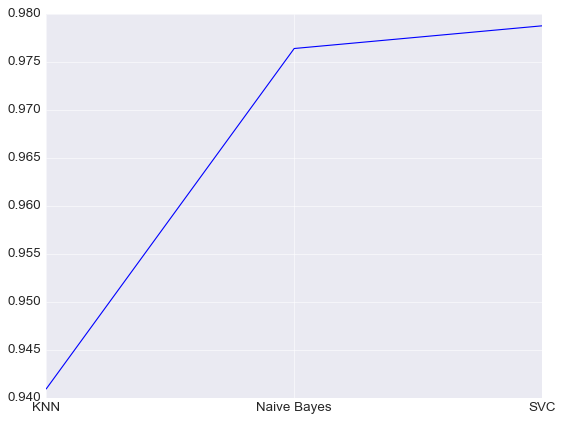

In [66]:
accuracyList_plot=[knn_accuracy,nb_accuracy,svc_accuracy]
sns.set_style("darkgrid")
plt.plot(accuracyList_plot)
plt.xticks(np.arange(0, 3, 1.0))
plt.xticks(np.arange(3), ('KNN', 'Naive Bayes', 'SVC'))
plt.show()

<b>Performing Cross Validation on the 3 classifiers with 10 folds. In KFold cross validation the dataset is split into K-Folds such that each time, one of the k subsets is used as the test set/ validation set and the other k-1 subsets are put together to form a training set.The error estimation is averaged over all k trials to get total effectiveness of our model. The sklearn cross_val_score was used to conduct the cross validation on each of the classifiers and their outputs where noted and plotted using the matplitlib package</b>

In [67]:

from sklearn.model_selection import cross_val_score
#Naive Bayes cross validation
nbscore=cross_val_score(nb,X,catList, cv=10)


In [144]:
nbscore # accuracy values for each fold

array([1.        , 0.97163121, 0.95744681, 0.9858156 , 0.95035461,
       0.9787234 , 1.        , 0.97857143, 0.99285714, 0.97142857])

In [ ]:
#Knn cross validation
knn = KNeighborsClassifier(n_neighbors=3)
knnscore=cross_val_score(knn,X,catList, cv=10)

In [145]:
knnscore # accuracy scores for each fold

array([0.97202797, 0.95744681, 0.95744681, 0.97163121, 0.95035461,
       0.96453901, 0.97142857, 0.96428571, 0.97142857, 0.97142857])

In [ ]:
#SVC cross validation
svcscore=cross_val_score(svc,X,catList, cv=10)

In [146]:
svcscore # accuracy scores for each fold

array([1.        , 0.9858156 , 0.97163121, 0.97163121, 0.97163121,
       0.9787234 , 1.        , 0.97857143, 0.99285714, 0.97857143])

In [143]:
crossValCompare

,CrossVal Scores,Before CrossVal
KNN,0.965202,0.940898
Naive Bayes,0.978683,0.976359
SVC,0.982943,0.978723


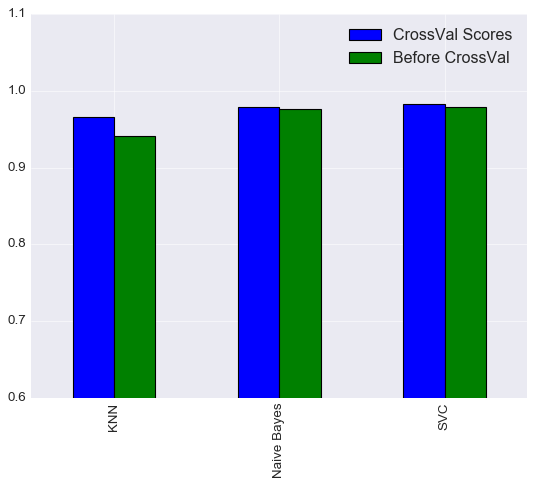

In [134]:
dfList=[[knnscore.mean(),knn_accuracy],[nbscore.mean(),nb_accuracy],[svcscore.mean(),svc_accuracy]]
crossValCompare=pd.DataFrame(dfList)
crossValCompare.columns=["CrossVal Scores","Before CrossVal"]
crossValCompare.index=["KNN","Naive Bayes","SVC"]
crossValCompare.plot.bar()
plt.ylim(0.6,1.1)
plt.show()
                            

<h3><font color="red">Inference</font></h3>
<b>
The cross validation scores for the three classifiers were evaluated and found out to be
- KNN : 96.52 which is 2 % more than the score without cross validation
- Multinomial Naive Bayes : 97.86 which is 0.2% more that the score without cross validation
- Linear SVC :  98.29% which is 0.4% more that the score without cross validation

So cross validation scores gave a better idea of the accuracy scores of different classifiers by performing 10 fold cross validation and showed that among the 3 chosen classifiers Linear SVC is the best performing.
</b>

<h3><font color="red">Grid Search</h3>

<b>KNN Grid Search</b>

In [71]:
#Performing Grid Search CV
from sklearn.grid_search import GridSearchCV
#performing grid search on knn to find the best parameter combination
knn = KNeighborsClassifier()
k_range = [3,4,5,6,7] # to find best k value among the given values in the list
param_grid = dict(n_neighbors=k_range)
gridKNN= GridSearchCV(knn,param_grid,cv=10,scoring='accuracy')
gridKNN.fit(X_train,y_train)
gridKNN.best_params_

{'n_neighbors': 4}

<b>Among the parameters given to grid search it was found that the best value for n_neighbours was found to be 4 that is the model will consider 4 of its nearest samples for its classification to measure similarity between the unknown data sample</b>

In [72]:
# Make a set of predictions for the test data
y_pred =gridKNN.predict(X_test) #making the trained classifier predict on the test data set.
#performance
knn_accuracy_grid = metrics.accuracy_score(y_test, y_pred) #comparing the predicted values with the target values.
print("Accuracy: " +  str(knn_accuracy_grid))
print(metrics.classification_report(y_test, y_pred))


Accuracy: 0.9479905437352246
             precision    recall  f1-score   support

          0       0.94      0.95      0.94       149
          1       0.97      0.96      0.96       158
          2       0.93      0.94      0.94       116

avg / total       0.95      0.95      0.95       423



<b>Linear SVC Grid Search</b>

In [97]:
#performing grid search on knn to find the best parameter combination
svc=LinearSVC()
C_range = [0.00001,0.001,0.01,0.5,1] # to find best C value among the list
dual_list=[True,False]
param_grid = dict(C=C_range,dual=dual_list)
gridSVC= GridSearchCV(svc,param_grid,cv=10,scoring='accuracy')
gridSVC.fit(X_train,y_train)
gridSVC.best_params_

{'C': 0.5, 'dual': True}

<b>
* C is the parameter which tells how much of misclassification can happen with each training example.
>* Large C will corresponds to optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly
>* Small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points

* Dual - Select the algorithm to either solve the dual or primal optimization problem

ref:http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel
<b>

In [99]:
gridSVC.predict(X_test) #making the trained classifier predict on the test data set.
#performance
svc_accuracy_grid = metrics.accuracy_score(y_test, y_pred) #comparing the predicted values with the target values.
print("Accuracy: " +  str(svc_accuracy_grid))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.9787234042553191
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       149
          1       0.99      0.98      0.98       158
          2       0.97      0.97      0.97       116

avg / total       0.98      0.98      0.98       423



<b> Multinomial Naive Bayes Grid Search </b>

In [84]:
nb=MultinomialNB()
nb.fit(X_train,y_train)#training
fitPrior_list=[True,False]
aplha_list=[0.00001,0.0001,0.001,0.01,0.1,0.5,1]
param_grid = dict(alpha=aplha_list,fit_prior=fitPrior_list)
gridNB= GridSearchCV(nb,param_grid,cv=10,scoring='accuracy')
gridNB.fit(X_train,y_train)
gridNB.best_params_


{'alpha': 0.1, 'fit_prior': False}

<b>
* Alpha - Is a smoothing parameter which handles the Zero Frequency Error.
* Fit_Prior - Decides whether to learn class prior probabilities or not. If false, a uniform prior will be used. 

ref:http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
</b>

In [100]:
gridNB.predict(X_test) #making the trained classifier predict on the test data set.
#performance
nb_accuracy_grid = metrics.accuracy_score(y_test, y_pred) #comparing the predicted values with the target values.
print("Accuracy: " +  str(nb_accuracy_grid))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.9787234042553191
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       149
          1       0.99      0.98      0.98       158
          2       0.97      0.97      0.97       116

avg / total       0.98      0.98      0.98       423



In [101]:
#plot showing comparison of before and after gridsearch cv
grid_accuracy_scores=[knn_accuracy_grid,nb_accuracy_grid,svc_accuracy_grid] # grid scores
accuracyList_plot # normal accuracy scores
df1=pd.DataFrame(grid_accuracy_scores,columns=["GridScores"])
df2=pd.DataFrame(accuracyList_plot,columns=["Before Grid"])
merged=pd.concat([df1,df2],axis=1)
merged.index=["KNN","Naive Bayes","SVC"]

In [102]:
merged # before grid search and after grid search score comparison.

,GridScores,Before Grid
KNN,0.947991,0.940898
Naive Bayes,0.978723,0.976359
SVC,0.978723,0.978723


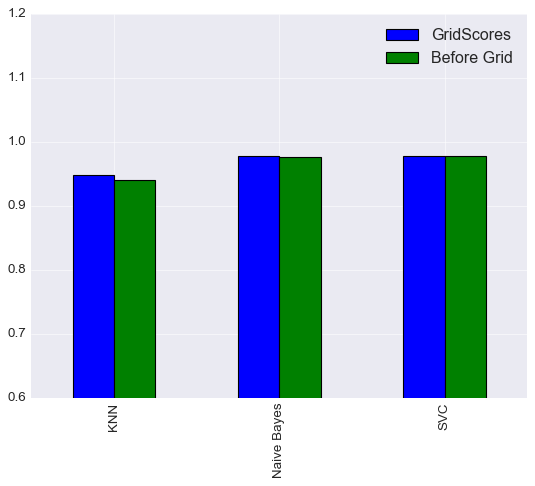

In [103]:

merged.plot.bar()
plt.ylim(0.6,1.2)
plt.show()

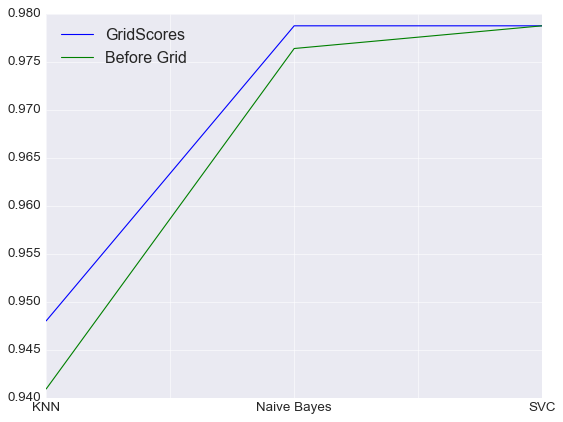

In [104]:
import matplotlib.pyplot as p1
merged[["GridScores","Before Grid"]].plot()
p1.show()

<b>The graph shows that performing grid search on the classifiers resulted in finding better parameters for the classifiers which yielded better results than the default ones as the blue line in the graph which depicts grid model scores are is always above the green line which represents the before grid search scores which implies that the grid search result models is better than the non grid based models. As it is evident from the graph it is clear that KNN has the highest rate of increase while the before and after grid search scores doest show improvement for SVC. Grid search was effective in finding more suitable parameters for the classifiers to get better performance.  </b>

<b>Cross Validating Grid Selected Models</b>

In [235]:
kscore=cross_val_score(gridKNN,X,catList, cv=10)
kscore.mean()

0.9595128275979338

In [231]:
nscore=cross_val_score(gridNB,X,catList, cv=10)
nscore.mean()

0.9758257345491387

In [234]:
svcScore=cross_val_score(gridSVC,X,catList,cv=10)
svcScore.mean()

0.9843617021276595

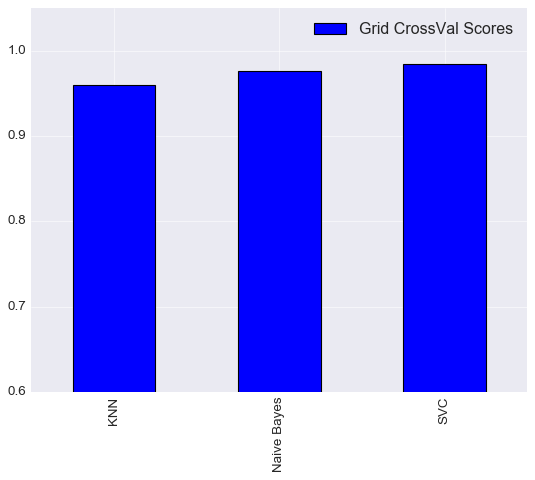

In [239]:
gridCross=[kscore.mean(),nscore.mean(),svcScore.mean()]
gridCrossValCompare=pd.DataFrame(gridCross)
gridCrossValCompare.columns=["Grid CrossVal Scores"]
gridCrossValCompare.index=["KNN","Naive Bayes","SVC"]
gridCrossValCompare.plot.bar()
plt.ylim(0.6,1.05)
plt.show()
              

In [241]:
gridCrossValCompare

,Grid CrossVal Scores
KNN,0.959513
Naive Bayes,0.975826
SVC,0.984362


<b>The plot shows the cross validation scores of the grid selected models on the whole data set
- It can be seen that the cross validation analysis of the grid selected for SVC has the highest accuracy (mean of 10 folds) of 98.4% 
- 2nd Highest being Naive Bayes with accuracy of 97.58
- Least being KNN with 95.9513% accuracy

- Inference -So the cross validation analysis shows that the SVC classifier performs the best in the considered scenario.
</b>

<h3><font color="red">Cohen Kappa</h3>

<b>To measure the agreement between the classifiers. Cohen Kappa score for the predictions of classifiers were found and output to a matrix. The Cohen Kappa score is a good way to measure the similarity between the predicted values of the classifiers and shows how diverse the classifiers are.</b>

In [147]:
models

[MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform')]

In [63]:
from sklearn.metrics import cohen_kappa_score

#comparing the performance of two classifiers.
#Evaluating the disagreement between the classifiers using Kohen Kappa
models=[nb,svc,knn]
for model in models: # training the models
    model.fit(X,catList)
kappa_matrix = np.zeros((len(models), len(models))) # creating a np zero array to store the cohen kappa values
for i in range(len(models)):
    for j in range(len(models)):
        p1=models[i].predict(X)
        p2=models[j].predict(X)
        kappa = cohen_kappa_score(p1, p2, labels=None, weights=None) #Calculating the cohen kappa values for the 
                                                                    #predictions of the classifiers
        kappa_matrix[i][j] = kappa #storing the cohen kappa values in the matrix against the correct cell.
      


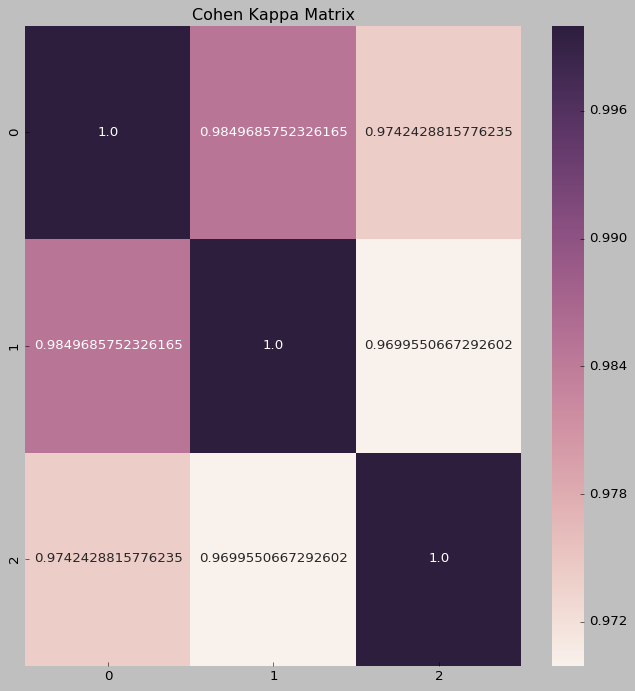

In [64]:
plt.figure(figsize=(10,10))
plt.title("Cohen Kappa Matrix")
sns.heatmap(kappa_matrix, annot=True,  fmt='')
plt.show()

<b>Cohen Kappa values closer to 1 shows higher similarities in the prediction while smaller numbers tend to show that classifiers are least similar.
- Highest Similarity : Multinomial Naive Bayes - Linear SVC - 0.984968
- Least similarity : Linear SVC - KNN - 0.96995

So it can be infered that the NaiveBayes and SVC Models predict the most similar predictions whicle the least similar ones are between Linear SVC and KNN.
</b>

<b>Function to plot the confusion heatmap for the classifiers based on the confusion mattrices for each of the classifiers. The SeaBorn package was used to plot the heatmap</b>

In [148]:
#The function to print the confusion heatmap of the confusion matrices of the classifiers
def confusionHeatMap(Xtest,YTest,models):
    confusion_aggregate=[]
    print("Models")
    print(models)
    labels=["Multinomial Naive Bayes","Linear SVC","KNN"]
    for i,model in enumerate(models):
       # print("here")
        pr=model.predict(Xtest)
       # print("there")
       # print(pr)
        matrix=metrics.confusion_matrix(YTest,pr)# calculating the confusion matrix for each classifier
        confusion_aggregate.append(matrix) #storing the confusion matrices to a list.
            
    storage={
    1:{
        'matrix':confusion_aggregate[0],
        'title':labels[0]
    }, 
    2:{
        'matrix':confusion_aggregate[1],
        'title':labels[1]
    }, 
    3:{
        'matrix':confusion_aggregate[2],
        'title':labels[2]
    }
    }
    #plotting the heatmaps for the confusion matrices
    fix, ax = plt.subplots(figsize=(15, 10))
    plt.suptitle('Confusion Matrix of Various Classifiers')
    for i, values in storage.items():
            matrix = values['matrix']
            title = values['title']
            plt.subplot(3, 4, i) # starts from 1
            plt.title(title)
            sns.heatmap(matrix, annot=True,  fmt='')
    plt.show()

Models
[MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')]


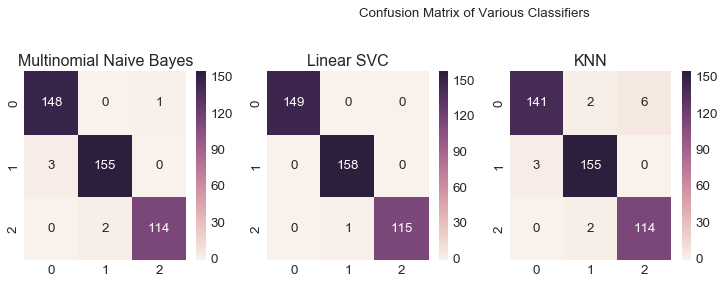

In [149]:
#calling the function to plot the heatmap of confusion matrices.

confusionHeatMap(X_test,y_test,models)

<b>It can be infered from the comparison of the confusion matrices that the Linear SVC does the best job in classying the text items into their corresponding target classes.

* Linear SVC
>* Classifies only one text item wrong in the given test dataset which belongs to the Techonology Category but was classified as a Sport Article.

* Multinomial Naive Bayes
>* Classifies articles that belongs to Sport Category wrong the most with 3 being misclassified as Business Articles.
>* Classifies 2 Techonology Articles as Sport Articles.
>* Classifies 1 Business Article as Techonology Article.

* KNN
>* Classifies 6 Business Articles as Technology
>* Classifies 2 Business and Technolody article as Sport Article.
>* Classifies 3 Sport articles as Business Article


The data that we have being skewed, that is the number of categories that each article belongs to is not properly distributed in the dataset. So the accuracy is not the best performance measure to compare classifiers rather their confusion matrix shows more insight to how they are performing. 

* Here it is clear that the Linear SVC performs the best among the set of classifiers both in accuracy as well as does a really good job in classifying the articles into their corresponding classes.
</b>

<h3><b><font color="red">Cosine Similarity</b></h3>

<b>Cosine Similarity of the collective list of documents of the corresponding categories were found to figure out the similarity between the content of different categories and how much they are similar.

- Cosine Similarity is the angle between term vectors.
- Cosine similarity score is 1 if two documents are identical and 0 if two documents share no terms in common.

ref:https://csmoodle.ucd.ie/moodle/pluginfile.php/62994/mod_resource/content/4/12%20-%20Text%20Mining.pdf
</b>

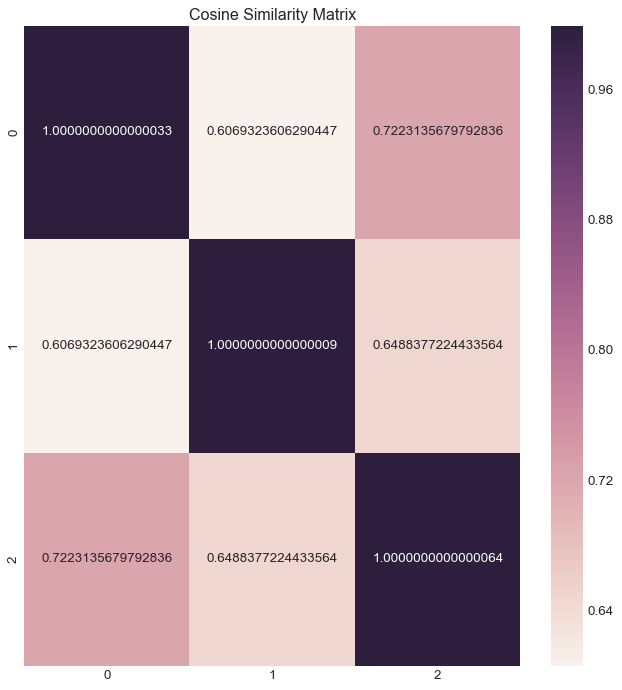

In [212]:
#loading data for cosine similarity
business_articles=[]
sport_articles=[]
technology_articles=[]
listarr=[[],[],[]]
temp=[]
for name in filenames:
    fin = open("./TextFiles/"+name,"r")
    raw_documents = fin.readlines()
    fin.close()
    cat=name[-5:-4]
    listarr[int(cat)].extend(raw_documents)
listarr[0]=" ".join(listarr[0])
listarr[1]=" ".join(listarr[1])
listarr[2]=" ".join(listarr[2])

from sklearn.feature_extraction.text import TfidfVectorizer
ccc= TfidfVectorizer(stop_words="english",min_df = 3,tokenizer=lemma_tokenizer,ngram_range=(1,2))
ccc_data=ccc.fit_transform(listarr)


cosMatrix = np.zeros((len(listarr), len(listarr)))
from sklearn.metrics.pairwise import cosine_similarity
cosine = cosine_similarity(ccc_data[0],ccc_data[1])
for i in range(len(listarr)):
    j=0
    ll=[]
    while j<len(listarr):
        cos=cosine_similarity(ccc_data[i],ccc_data[j])
        ll.append(cos[0][0])
        cosMatrix[i][j]=cos[0][0]
        j=j+1   
        
plt.figure(figsize=(10,10))
plt.title("Cosine Similarity Matrix")
sns.heatmap(cosMatrix, annot=True,  fmt='')
plt.show()



<b>
The cosine similarity between the different collective documents of each text category was found
- Most Similar: Business-Technology - cosine value = 0.72231
- Least Similar: Business-Sport - cosine value = 0.606932

This shows that there is some similar words/terms in the business-technology categories which is infered from the higher cosine values.

Note: It was found from KNN confusion matrix that the it classified 6 Business articles as technology which might because of this high similarity which was found out after cosine similarity analysis. So the misclassification could be a direct result of the words being common and they were considered for the classification purpose.
<b>

### <font color="red">Word Cloud</font>

<b>WordCloud is an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance.</b>

<b>Word Cloud for Business Documents</b>

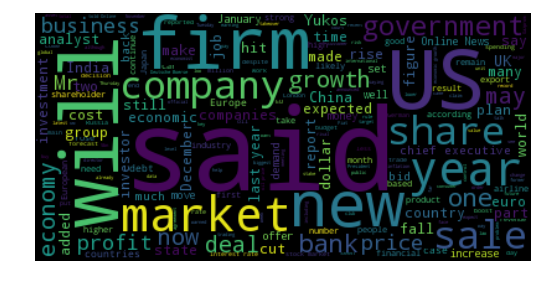

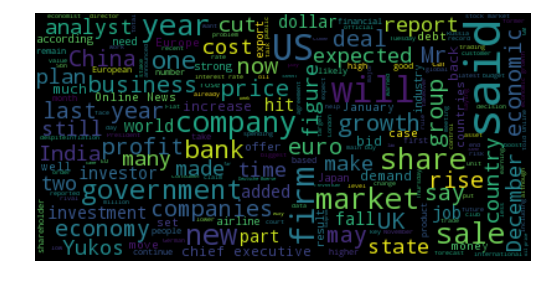

In [223]:
from wordcloud import WordCloud
text=listarr[0]
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<b>Word Count generated for Business Related documents show prominent words like market,company,growth,share,firm,bankprice etc which are terms clearly related to business domain and shows that business related documents contain these words more in frequency and importance</b>

<b>Word Count for Sports Documents</b>

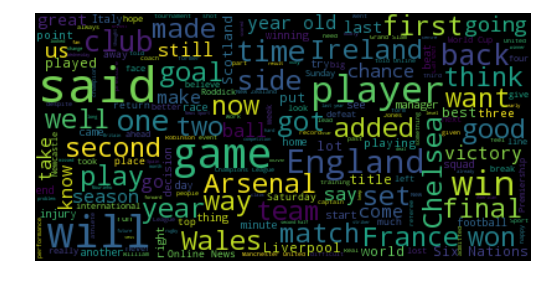

In [224]:
from wordcloud import WordCloud
text=listarr[1]
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<b>Word Count generated for Sport Related documents show prominent words like Player,game,win,final,match,won,goal etc which are terms clearly related to sports domain and shows that sports related documents contain these words more in frequency and importance</b>

<b>Word Count for Technology Documents</b>

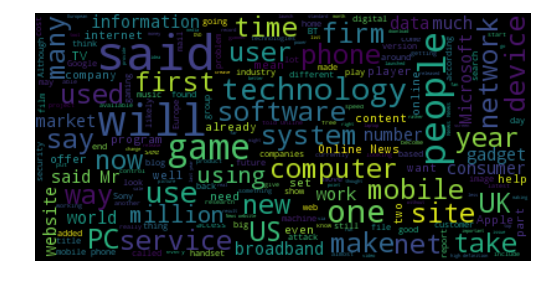

In [225]:
from wordcloud import WordCloud
text=listarr[2]
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<b>Word Count generated for Technology Related documents show prominent words like computer,mobile,service,information,website,gadget etc which are terms clearly related to technology domain and shows that technology related documents contain these words more in frequency and importance</b>

### <font color="red">Conclusion</font>
<b>
- The Documents were scrapped from the sites by traversing to each of the links found in the main page and then article content was then saved to corresponding files with their category values appended to the names to make it easier to map the categories to each article while training the classifier. 
- The Documents were then fetched back and then loaded to a list of string which was then preprocessed Tokenized -> Stop Words Removed -> Infrequent Terms Removed (Less than 3) -> 1 and 2 grams taken -> Lemmatized then the TF-IDF matrix for each of the documents were then calculated and then was used as the training data set and its corresponding categories were loaded and stored in a list which was used as the target dataset. 
- The 3 Classifiers the KNN, Multinomial Naive Bayes and the Linear SVC Classifiers were then imported from the sklearn packaged and were trained on the data which was split into training and testing. The training data(List of Tf_IDF Matirces) were then used to train the models and the test data was used to evaluate the performance. The cross validation function cross_val_score was then used to do cross validation on the three classifiers to get a better and standardized understanding of the performance of the classifiers. 
- All 3 classifiers tend to perform well but logisitc regression tends to be the best performing of the three. The accuracies were then plotted to get a better picture to compare and contrast between the performances of the classifiers. After the analysis it was found out that the Linear SVC among the set of the tested classifiers tends to be the best with an Cross Validation Accuracy Score and performed better in other analysis as well. So it is concluded from the analysis that Linear SVC is the best suit for the scenario here to classify documents to their categories. 
- Text Classification problems tends to be of high dimensionality, that is many features.

<font color="blue">KNN Classifier</font>
- The KNN classifier has a cross validation score of 96.52% accuracy which is pretty good in terms of classifying the documents. 
- Since the training data is of high dimensionality the KNN might tend to perform poorer as KNN works the best with lower dimensionality data.
- Computational cost might be higher because each query instance has to be compared to every point in the training data set which will then have to calculate the distance between each of the training data points and the query instance.
- Words are a good representation of features and thus KNN tends to perform well with text classification problems even though not as much as the other two considered classifiers.

<font color="blue">Multinomial Naive Bayes</font>
- Multinomial Naive Bayes is a more specialized version of the Naive Bayes classifier more suited for text classification.
- The difference is simple naive bayes classifier will model the document as the presence and absence of specific words while the Multionomial version explicitly models he word counts and adjusts the underlying calculations to deal with it.
-MultinomialNB is used commonly in text classification where data is represented as word counts or tf-idf vector.
- This shows why MultinomialNB tends to perform well with text classification and was seen from the analysis to be doing a really good job at text classification.
- The time required to train Multinomial Naive Bayes is less so is useful in cases when the time is a factor.
- Estimates the conditional probability of a particular word/term/token given a class as the relative frequency of term t in documents belonging to class c.Thus this variation takes into account the number of occurrences of term t in training documents from class c, including multiple occurrences which makes it a really good text classification candidate.

ref:http://www.cs.cmu.edu/~knigam/papers/multinomial-aaaiws98.pdf
http://blog.datumbox.com/machine-learning-tutorial-the-naive-bayes-text-classifier/


<font color="blue">Linear SVC</font>
- Linear SVC works very well for text Classification problems due to the following reasons
>* Most of the text classification problems are linearly seperable.
>* Text has a lot of features
>* Linear Kernel tends to be faster.
>* There are lesser parameters to optimize in Linear SVC mainly being just the C value.

ref:https://www.svm-tutorial.com/2014/10/svm-linear-kernel-good-text-classification/

<font color="red">Conclusion:</font> 
- All the considered classifiers did a good job at text classification and among the set MultinomialNB and Linear SVC performed really well.
- The fact that MultinomialNB is a easier to train and Linear SVC being hard to tune is a deciding factor in choosing which one to pick for text classification.
- In the conducted analysis Linear SVC was found to give the best classification scores and other performance metrices among the three.


</b>

<b>Refernces
- https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english
- https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
- https://www.sciencedirect.com/science/article/pii/S1877705814003750
- https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
- https://en.wikipedia.org/wiki/Support_vector_machine
- http://www.cs.cmu.edu/~knigam/papers/multinomial-aaaiws98.pdf
- https://github.com/amueller/word_cloud


</b>
